In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

We got equations: 
$$
\begin{cases}
\frac{dG}{dt} = (p_1 - X) G + p_4 \\
\frac{dX}{dt} = p_2 X + p_3 I(t)
\end{cases}
$$

Let's first generate G

In [3]:
def getI(t, I_max, a=1, t1=10):
    return I_max / np.cosh(a * (t - t1))

def find_g(p1, p2, p3, p4, p5, X0, I_max, T, step=1):
    '''
    Modelat G with given parameters
    '''
    g = [p5]
    x = [X0]
    
    for t in range(int(T * step)):
        dg_dt = (p1 - x[-1]) * g[-1] + p4
        dx_dt = p2 * x[-1] + p3 * getI(t / step, I_max)
        
        g.append(g[-1] + dg_dt / step)
        x.append(x[-1] + dx_dt / step)
        
    return np.array(g), np.array(x)

In [4]:
p1 = -4.9 / 1e2
p2 = -9.1 / 1e2
p3 = 8.96 / 1e5
p4 = 4.42

p5 = 150
X0 = 0.1
I_max = 100

In [5]:
step = 100
T = 60
G, X = find_g(p1, p2, p3, p4, p5, X0, I_max, T, step)
I = [getI(t / step, I_max) for t in range(int(T * step) + 1)]

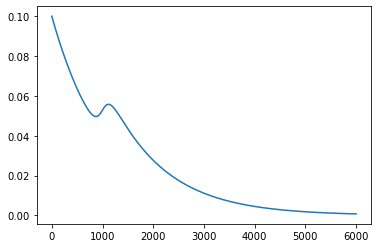

In [6]:
plt.plot(X)

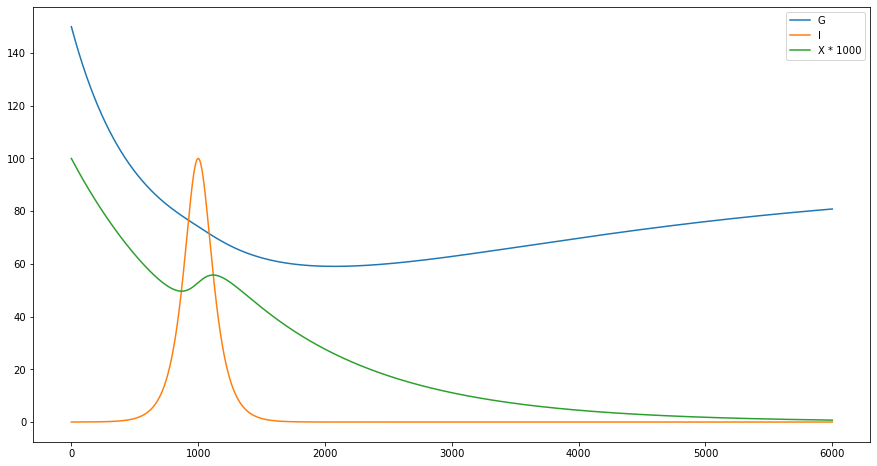

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(G, label='G')
plt.plot(I, label='I')
plt.plot(X * 1000, label='X * 1000')
plt.legend()

# TODO
put different left and right scales

Let's prove numerically that this problem non-observable. To do so we'll find infinite number parameters for the same G that fit equations

In [8]:
X[:5] * G[:5]

array([15.        , 14.96843754, 14.93696038, 14.90556826, 14.8742609 ])

In [44]:
def get_params_basic(p2, p3, G, I, X0, step):
    '''
    For given G, I, p_2, p_3 and X(0) find p_1, p_4 that fit equations and r2_score of that fit
    '''

    X_ = [X0]

    #find X from second equation
    for pos, g in enumerate(G[:-1]):
        dx_dt = p2 * X_[-1] + p3 * I[pos]
        X_.append(X_[-1] + dx_dt / step)

    #find p1, p2, p3 from first equation
    Y = (G[1:] - G[:-1]) * step + X_[1:] * G[1:]
    Z = G[:-1].reshape(-1, 1)

    model = LinearRegression().fit(Z[:], Y[:])
    y_pred = model.predict(Z[:])
           
    return r2_score(y_pred, Y), model.coef_, model.intercept_

def get_params_pro(p2, p3, G, I, X0, step):
    '''
    For given p2, p3, I and G trying to find X0 (close to one that user defined), so r2_score is best
    Print that r2_score and return p_1, p_4
    '''
    grid = np.arange(0, 1.001, 0.05)
    r2_scores = [get_params_basic(p2, p3, G, I,  X0 * coef, step)[0] for coef in grid]
    best_coef = grid[np.argmax(r2_scores)]
    res = get_params_basic(p2, p3, G, I, X0 * best_coef, step)
    print("R2 score of fit:", round(res[0], 4))
    
    return res[1:]

Now for different $p_4$ we'll find different $p_1, p_2, p_3$ that fit equations

In [60]:
res = []
for p2_ in np.arange(0.2, 1.001, 0.05) * p2:
    p3_ = p3
    print("p_2={}".format(round(p2_, 4)),end=' ')
    [p1_,], p4_ = get_params_pro(p2_, p3_, G[::step], I[::step], X0, 1)
    res.append([p1_, p2_, p3_, p4_])
res = np.array(res)

p_2=-0.0182 R2 score of fit: 0.9588
p_2=-0.0228 R2 score of fit: 0.9895
p_2=-0.0273 R2 score of fit: 0.9947
p_2=-0.0318 R2 score of fit: 0.9963
p_2=-0.0364 R2 score of fit: 0.997
p_2=-0.0409 R2 score of fit: 0.9973
p_2=-0.0455 R2 score of fit: 0.9972
p_2=-0.05 R2 score of fit: 0.9971
p_2=-0.0546 R2 score of fit: 0.997
p_2=-0.0591 R2 score of fit: 0.9967
p_2=-0.0637 R2 score of fit: 0.9963
p_2=-0.0682 R2 score of fit: 0.9967
p_2=-0.0728 R2 score of fit: 0.9966
p_2=-0.0773 R2 score of fit: 0.997
p_2=-0.0819 R2 score of fit: 0.998
p_2=-0.0864 R2 score of fit: 0.9966
p_2=-0.091 R2 score of fit: 0.9912


Here you can see how parameters change

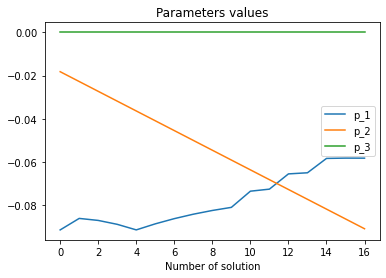

In [61]:
plt.xlabel('Number of solution')
plt.title('Parameters values')
plt.plot(res[:, 0], label='p_1')
plt.plot(res[:, 1], label='p_2')
plt.plot(res[:, 2], label='p_3')
plt.legend()

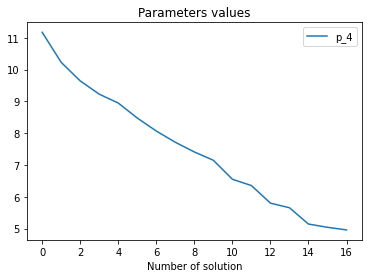

In [62]:
plt.xlabel('Number of solution')
plt.title('Parameters values')
plt.plot(res[:, 3], label='p_4')
plt.legend()

But problem is identifiable:

In [72]:
Y = (G[1:] - G[:-1]) * step + X[1:] * G[1:]
Z = G[:-1].reshape(-1, 1)
model = LinearRegression().fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
print('R2 score:', r2_score(y_pred, Y))
[p1_], p4_ = model.coef_, model.intercept_

Y = (X[1:] - X[:-1]) * step
Z = np.vstack([X[:-1], I[:-1]]).T
model = LinearRegression(fit_intercept=False).fit(Z[:], Y[:])
y_pred = model.predict(Z[:])
print('R2 score:', r2_score(y_pred, Y))
[p2_, p3_], _ = model.coef_, model.intercept_

print("Predicted p1={}, p2={}, p3={}, p4={}".format(p1_, p2_, p3_, p4_))
print("True p1={}, p2={}, p3={}, p4={}".format(p1, p2, p3, p4))

R2 score: 0.9999884497606308
R2 score: 1.0
Predicted p1=-0.04928044621580921, p2=-0.09099999999999997, p3=8.960000000000006e-05, p4=4.438195307508509
True p1=-0.049, p2=-0.091, p3=8.960000000000001e-05, p4=4.42
